# Raylegh Taylor instability with Free-Slip

![Kaus2010_figure1.png](./Kaus2010_figure1.png)

Rayleigh–Taylor instability of a dense, more viscous layer ($\rho$ = 3300 kg/m3 , $\mu = 1e21$ Pa s), sinking through a less dense fluid ( = 3200 kg/m3 ,  = 1020 Pa s). Side boundaries
are free slip, the lower boundary is no-slip and the upper boundary is a free surface. The box is 500 × 500 km in size, and gravitational acceleration was 9.81 m/s2 . The initial
perturbation was sinusoidal with initial amplitude of 5 km. A constant time step of 2500 years (A) or 5000 years (B) was employed, with Q2 P−1 quadrilateral elements and
51 × 51 nodes. Whereas the 2500 years simulation evolves smoothly, the simulation with t = 5000 years results in a sloshing instability, in which the velocity pattern
changes direction from one time step to the other.

In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

loaded rc file /opt/venv/lib/python3.9/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
half_rate = 1.0 * u.centimeter / u.year
model_length = 500 * u.km
bodyforce = 3300 * u.kg / u.m**3 * 9.81 * u.m / u.s**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

## Model Geometry

In [4]:
gravity_vector = (0.0, -9.81 * u.m / u.s**2)

In [5]:
Model = GEO.Model(elementRes=(50, 50), 
                  elementType="Q2/dPc1",
                  minCoord=(-250. * u.km, -500. * u.km), 
                  maxCoord=(250. * u.km, 0. * u.km), 
                  gravity=gravity_vector)

	Global element size: 50x50
	Local offset of rank 0: 0x0
	Local range of rank 0: 50x50


In [6]:
Model.outputDir="outputs_kaus2010_FreeSlip"

In [7]:
import underworld.function as fn

In [8]:
import numpy as np

amplitude = GEO.non_dimensionalise(5*u.km)
period = GEO.non_dimensionalise(Model.length)  #* 2.0
interface_depth = GEO.non_dimensionalise(100*u.km)
func = -interface_depth + (amplitude * fn.math.cos(2.0*np.pi*fn.input()[0]/period))

shape = fn.input()[1] < -interface_depth + (amplitude * fn.math.cos(2.0*np.pi*fn.input()[0]/period))

In [9]:
HD_material = Model.add_material(name="HD_material", shape=GEO.shapes.Layer(top=Model.top, bottom=Model.bottom))
LD_material = Model.add_material(name="LD_material", shape=shape)

In [10]:
npoints = 250
coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = -interface_depth + (amplitude * np.cos(2.0*np.pi*coords[:, 0]/period))
#surf_tracers = Model.add_passive_tracers(name="Surface",vertices=coords)
Model.add_passive_tracers(name="Surface", vertices=coords)


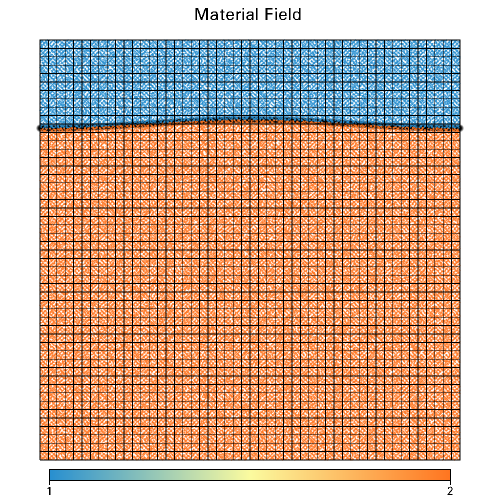

In [11]:
Fig = vis.Figure(figsize=(500,500), title="Material Field", quality=2)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.Mesh(Model.mesh)
Fig.Points(Model.Surface_tracers, pointSize=8.0)
Fig.show()

In [12]:
LD_material.density = 3200 * u.kilogram / u.meter**3
HD_material.density = 3300 * u.kilogram / u.meter**3
LD_material.viscosity = 1e20 * u.pascal * u.second
HD_material.viscosity = 1e21 * u.pascal * u.second

## Boundary Conditions

In [13]:
Model.set_kinematicBCs(left=[0., None],
                       right=[0., None],
                       top=[None, 0.],
                       bottom=[None,0.],
                       order_wall_conditions=[ "top", "left", "right", "bottom"])

In [14]:
#Model.freeSurface = True

In [15]:
#Model.fssa_factor = 1.0

# Compute initial condition

In [16]:
Model.init_model(pressure="lithostatic")

/opt/venv/lib/python3.9/site-packages/UWGeodynamics/_model.py:1566: UserWarning: Skipping the steady state calculation: No diffusivity variable defined on Model
  warnings.warn("Skipping the steady state calculation: No diffusivity variable defined on Model")



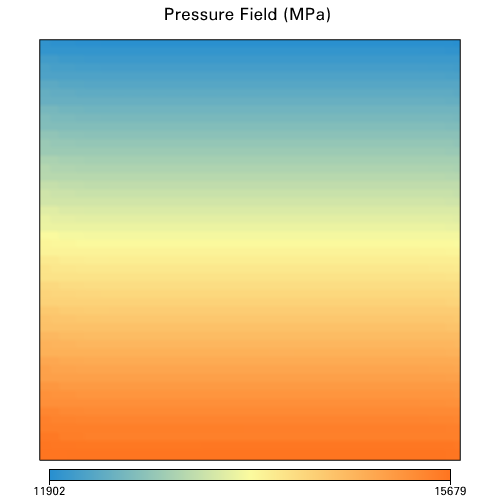

In [17]:
Fig = vis.Figure(figsize=(500,500), title="Pressure Field (MPa)", quality=3)
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.megapascal))
Fig.show()


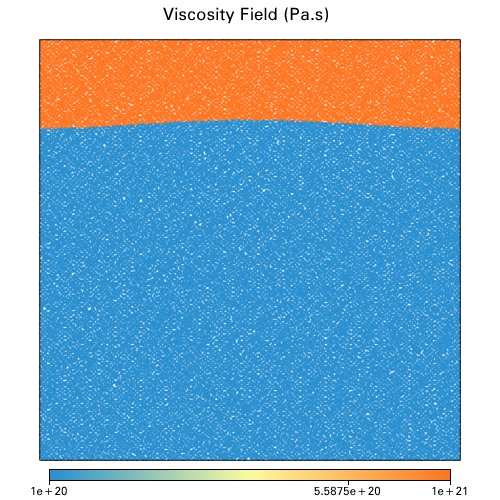

In [18]:
Fig = vis.Figure(figsize=(500,500), title="Viscosity Field (Pa.s)", quality=3)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.show()


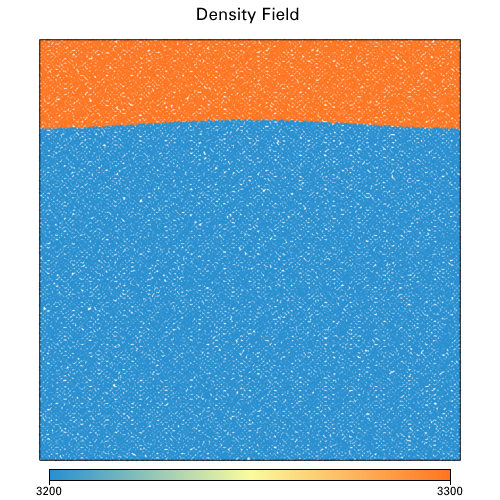

In [19]:
Fig = vis.Figure(figsize=(500,500), title="Density Field", quality=3)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.densityField, u.kg / u.m**3),
           fn_size=3.0)
Fig.show()

## Solver options

In [20]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-4

outputss=['pressureField',
         'strainRateField',
         'velocityField',
          'projTimeField',
           'projMaterialField',
         'projViscosityField',
         'projStressField',
         'projDensityField',
         'projStressTensor',]
GEO.rcParams['default.outputs']=outputss

In [21]:
#Model.run_for(5.5 * u.megayears, checkpoint_interval=10000*u.year,dt=5000*u.year)

In [22]:
Model.run_for(nstep=1100, checkpoint_interval=1, dt=5000*u.year)

Running with UWGeodynamics version 2.12.1
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.035224 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01265 secs / 1 its
  Pressure Solve:         = 0.06618 secs / 5 its
  Final V Solve:          = 0.009894 secs / 1 its

  Total BSSCR Linear solve time: 0.375898 seconds

Linear solver (RP6SEKWH__system-execute), solution time 3.785403e-01 (secs)
Time Integration
	2nd order

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0853 [min] /    0.0853 [max] (secs)
Time Integration - 0.085353 [min] / 0.085353 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000221657 [min] / 0.000221657 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:     7 Model Time: 35000.0 year dt: 5000.0 year (2022-02-04 06:13:33)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.016726 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01234 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1070 [min] /    0.1070 [max] (secs)
Time Integration - 0.107074 [min] / 0.107074 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000301715 [min] / 0.000301715 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:    14 Model Time: 70000.0 year dt: 5000.0 year (2022-02-04 06:13:54)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024927 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02927 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0888 [min] /    0.0888 [max] (secs)
Time Integration - 0.0888927 [min] / 0.0888927 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000372299 [min] / 0.000372299 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:    21 Model Time: 105000.0 year dt: 5000.0 year (2022-02-04 06:14:16)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018630 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01352 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0910 [min] /    0.0910 [max] (secs)
Time Integration - 0.091079 [min] / 0.091079 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00025712 [min] / 0.00025712 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:    28 Model Time: 140000.0 year dt: 5000.0 year (2022-02-04 06:14:38)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018610 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01359 secs / 1 its
  Pressure Solve:       

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1059 [min] /    0.1059 [max] (secs)
Time Integration - 0.105933 [min] / 0.105933 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000301788 [min] / 0.000301788 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:    35 Model Time: 175000.0 year dt: 5000.0 year (2022-02-04 06:15:01)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.033558 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03828 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1336 [min] /    0.1336 [max] (secs)
Time Integration - 0.133684 [min] / 0.133684 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000258006 [min] / 0.000258006 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:    42 Model Time: 210000.0 year dt: 5000.0 year (2022-02-04 06:15:22)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019717 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01754 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0930 [min] /    0.0930 [max] (secs)
Time Integration - 0.0930429 [min] / 0.0930429 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000272974 [min] / 0.000272974 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:    49 Model Time: 245000.0 year dt: 5000.0 year (2022-02-04 06:15:42)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019735 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01561 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0946 [min] /    0.0946 [max] (secs)
Time Integration - 0.0946673 [min] / 0.0946673 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000369167 [min] / 0.000369167 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:    56 Model Time: 280000.0 year dt: 5000.0 year (2022-02-04 06:16:02)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019649 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0158 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0939 [min] /    0.0939 [max] (secs)
Time Integration - 0.0939217 [min] / 0.0939217 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000276938 [min] / 0.000276938 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:    63 Model Time: 315000.0 year dt: 5000.0 year (2022-02-04 06:16:23)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019740 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01455 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0960 [min] /    0.0960 [max] (secs)
Time Integration - 0.0959928 [min] / 0.0959928 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000383769 [min] / 0.000383769 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:    70 Model Time: 350000.0 year dt: 5000.0 year (2022-02-04 06:16:43)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019544 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01382 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0946 [min] /    0.0946 [max] (secs)
Time Integration - 0.0946874 [min] / 0.0946874 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000281778 [min] / 0.000281778 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:    77 Model Time: 385000.0 year dt: 5000.0 year (2022-02-04 06:17:04)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019708 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01465 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0939 [min] /    0.0939 [max] (secs)
Time Integration - 0.093965 [min] / 0.093965 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000263253 [min] / 0.000263253 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:    84 Model Time: 420000.0 year dt: 5000.0 year (2022-02-04 06:17:25)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019959 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01507 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0924 [min] /    0.0924 [max] (secs)
Time Integration - 0.0924335 [min] / 0.0924335 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000281884 [min] / 0.000281884 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:    91 Model Time: 455000.0 year dt: 5000.0 year (2022-02-04 06:17:45)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019788 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01449 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0950 [min] /    0.0950 [max] (secs)
Time Integration - 0.0950116 [min] / 0.0950116 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000270625 [min] / 0.000270625 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:    98 Model Time: 490000.0 year dt: 5000.0 year (2022-02-04 06:18:06)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019855 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01472 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0934 [min] /    0.0934 [max] (secs)
Time Integration - 0.0934641 [min] / 0.0934641 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000288286 [min] / 0.000288286 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   105 Model Time: 525000.0 year dt: 5000.0 year (2022-02-04 06:18:27)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020441 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01449 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0937 [min] /    0.0937 [max] (secs)
Time Integration - 0.0937549 [min] / 0.0937549 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000274621 [min] / 0.000274621 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   112 Model Time: 560000.0 year dt: 5000.0 year (2022-02-04 06:18:48)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019965 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01493 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0928 [min] /    0.0928 [max] (secs)
Time Integration - 0.092891 [min] / 0.092891 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000261366 [min] / 0.000261366 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   119 Model Time: 595000.0 year dt: 5000.0 year (2022-02-04 06:19:09)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019961 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01458 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0944 [min] /    0.0944 [max] (secs)
Time Integration - 0.0944736 [min] / 0.0944736 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000367413 [min] / 0.000367413 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   126 Model Time: 630000.0 year dt: 5000.0 year (2022-02-04 06:19:30)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019809 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01392 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0957 [min] /    0.0957 [max] (secs)
Time Integration - 0.0957688 [min] / 0.0957688 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000271869 [min] / 0.000271869 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   133 Model Time: 665000.0 year dt: 5000.0 year (2022-02-04 06:19:50)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019670 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01915 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0982 [min] /    0.0982 [max] (secs)
Time Integration - 0.098231 [min] / 0.098231 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000255031 [min] / 0.000255031 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   140 Model Time: 700000.0 year dt: 5000.0 year (2022-02-04 06:20:11)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020275 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01654 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0948 [min] /    0.0948 [max] (secs)
Time Integration - 0.0948275 [min] / 0.0948275 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000283807 [min] / 0.000283807 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   147 Model Time: 735000.0 year dt: 5000.0 year (2022-02-04 06:20:31)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019777 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02153 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0951 [min] /    0.0951 [max] (secs)
Time Integration - 0.0951502 [min] / 0.0951502 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000283345 [min] / 0.000283345 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   154 Model Time: 770000.0 year dt: 5000.0 year (2022-02-04 06:20:53)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020785 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01487 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0954 [min] /    0.0954 [max] (secs)
Time Integration - 0.095436 [min] / 0.095436 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000401036 [min] / 0.000401036 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   161 Model Time: 805000.0 year dt: 5000.0 year (2022-02-04 06:21:13)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020560 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01533 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0977 [min] /    0.0977 [max] (secs)
Time Integration - 0.097805 [min] / 0.097805 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000255109 [min] / 0.000255109 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   168 Model Time: 840000.0 year dt: 5000.0 year (2022-02-04 06:21:35)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019980 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01446 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1357 [min] /    0.1357 [max] (secs)
Time Integration - 0.135793 [min] / 0.135793 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000490576 [min] / 0.000490576 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   175 Model Time: 875000.0 year dt: 5000.0 year (2022-02-04 06:21:56)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020617 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01438 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0941 [min] /    0.0941 [max] (secs)
Time Integration - 0.094131 [min] / 0.094131 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000270722 [min] / 0.000270722 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   182 Model Time: 910000.0 year dt: 5000.0 year (2022-02-04 06:22:17)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020129 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01557 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0955 [min] /    0.0955 [max] (secs)
Time Integration - 0.0955675 [min] / 0.0955675 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000279151 [min] / 0.000279151 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   189 Model Time: 945000.0 year dt: 5000.0 year (2022-02-04 06:22:37)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020432 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01474 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0935 [min] /    0.0935 [max] (secs)
Time Integration - 0.0935416 [min] / 0.0935416 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000258398 [min] / 0.000258398 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   196 Model Time: 980000.0 year dt: 5000.0 year (2022-02-04 06:22:58)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019754 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01424 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0936 [min] /    0.0936 [max] (secs)
Time Integration - 0.0936662 [min] / 0.0936662 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000302485 [min] / 0.000302485 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   203 Model Time: 1.0 megayear dt: 5000.0 year (2022-02-04 06:23:19)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020132 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01428 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0964 [min] /    0.0964 [max] (secs)
Time Integration - 0.0964369 [min] / 0.0964369 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000277582 [min] / 0.000277582 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   210 Model Time: 1.0 megayear dt: 5000.0 year (2022-02-04 06:23:40)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020732 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02411 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0959 [min] /    0.0959 [max] (secs)
Time Integration - 0.0959552 [min] / 0.0959552 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000256418 [min] / 0.000256418 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   217 Model Time: 1.1 megayear dt: 5000.0 year (2022-02-04 06:24:01)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020484 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01442 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0954 [min] /    0.0954 [max] (secs)
Time Integration - 0.0954433 [min] / 0.0954433 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000268804 [min] / 0.000268804 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   224 Model Time: 1.1 megayear dt: 5000.0 year (2022-02-04 06:24:22)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020370 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0143 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0942 [min] /    0.0942 [max] (secs)
Time Integration - 0.0942998 [min] / 0.0942998 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000259213 [min] / 0.000259213 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   231 Model Time: 1.2 megayear dt: 5000.0 year (2022-02-04 06:24:43)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020166 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01436 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0963 [min] /    0.0963 [max] (secs)
Time Integration - 0.0963104 [min] / 0.0963104 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000260104 [min] / 0.000260104 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   238 Model Time: 1.2 megayear dt: 5000.0 year (2022-02-04 06:25:05)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020897 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01665 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0944 [min] /    0.0944 [max] (secs)
Time Integration - 0.0944401 [min] / 0.0944401 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000461057 [min] / 0.000461057 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   245 Model Time: 1.2 megayear dt: 5000.0 year (2022-02-04 06:25:26)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019947 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01442 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0936 [min] /    0.0936 [max] (secs)
Time Integration - 0.0937048 [min] / 0.0937048 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000285999 [min] / 0.000285999 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   252 Model Time: 1.3 megayear dt: 5000.0 year (2022-02-04 06:25:46)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020325 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01506 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1043 [min] /    0.1043 [max] (secs)
Time Integration - 0.104335 [min] / 0.104335 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000254204 [min] / 0.000254204 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   259 Model Time: 1.3 megayear dt: 5000.0 year (2022-02-04 06:26:07)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021009 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01461 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0930 [min] /    0.0930 [max] (secs)
Time Integration - 0.093035 [min] / 0.093035 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000243875 [min] / 0.000243875 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   266 Model Time: 1.3 megayear dt: 5000.0 year (2022-02-04 06:26:28)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020138 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01464 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0993 [min] /    0.0993 [max] (secs)
Time Integration - 0.0993781 [min] / 0.0993781 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000274775 [min] / 0.000274775 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   273 Model Time: 1.4 megayear dt: 5000.0 year (2022-02-04 06:26:49)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020556 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01426 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1028 [min] /    0.1028 [max] (secs)
Time Integration - 0.102892 [min] / 0.102892 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000277345 [min] / 0.000277345 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   280 Model Time: 1.4 megayear dt: 5000.0 year (2022-02-04 06:27:10)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019956 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0145 secs / 1 its
  Pressure Solve:       

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0967 [min] /    0.0967 [max] (secs)
Time Integration - 0.0967783 [min] / 0.0967783 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000271868 [min] / 0.000271868 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   287 Model Time: 1.4 megayear dt: 5000.0 year (2022-02-04 06:27:31)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020153 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01464 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0944 [min] /    0.0944 [max] (secs)
Time Integration - 0.094423 [min] / 0.094423 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00025606 [min] / 0.00025606 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   294 Model Time: 1.5 megayear dt: 5000.0 year (2022-02-04 06:27:52)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020041 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01413 secs / 1 its
  Pressure Solve:        

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1719 [min] /    0.1719 [max] (secs)
Time Integration - 0.172002 [min] / 0.172002 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000457979 [min] / 0.000457979 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   301 Model Time: 1.5 megayear dt: 5000.0 year (2022-02-04 06:28:16)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021063 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01436 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0980 [min] /    0.0980 [max] (secs)
Time Integration - 0.0980094 [min] / 0.0980094 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000271032 [min] / 0.000271032 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   308 Model Time: 1.5 megayear dt: 5000.0 year (2022-02-04 06:28:39)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019637 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0155 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0939 [min] /    0.0939 [max] (secs)
Time Integration - 0.0939213 [min] / 0.0939213 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000271259 [min] / 0.000271259 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   315 Model Time: 1.6 megayear dt: 5000.0 year (2022-02-04 06:29:00)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020391 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01509 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1559 [min] /    0.1559 [max] (secs)
Time Integration - 0.155926 [min] / 0.155926 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000461754 [min] / 0.000461754 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   322 Model Time: 1.6 megayear dt: 5000.0 year (2022-02-04 06:29:25)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030341 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01612 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0986 [min] /    0.0986 [max] (secs)
Time Integration - 0.0986242 [min] / 0.0986242 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000275271 [min] / 0.000275271 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   329 Model Time: 1.6 megayear dt: 5000.0 year (2022-02-04 06:29:48)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020948 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01447 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0973 [min] /    0.0973 [max] (secs)
Time Integration - 0.0973383 [min] / 0.0973383 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000302396 [min] / 0.000302396 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   336 Model Time: 1.7 megayear dt: 5000.0 year (2022-02-04 06:30:09)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020674 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01459 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0996 [min] /    0.0996 [max] (secs)
Time Integration - 0.0996109 [min] / 0.0996109 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000316412 [min] / 0.000316412 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   343 Model Time: 1.7 megayear dt: 5000.0 year (2022-02-04 06:30:30)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019730 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01463 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0965 [min] /    0.0965 [max] (secs)
Time Integration - 0.0965547 [min] / 0.0965547 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000311684 [min] / 0.000311684 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   350 Model Time: 1.7 megayear dt: 5000.0 year (2022-02-04 06:30:51)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019461 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01547 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0953 [min] /    0.0953 [max] (secs)
Time Integration - 0.0953522 [min] / 0.0953522 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000271407 [min] / 0.000271407 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   357 Model Time: 1.8 megayear dt: 5000.0 year (2022-02-04 06:31:12)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021649 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01453 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0988 [min] /    0.0988 [max] (secs)
Time Integration - 0.098883 [min] / 0.098883 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000319986 [min] / 0.000319986 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   364 Model Time: 1.8 megayear dt: 5000.0 year (2022-02-04 06:31:33)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020084 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01426 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0957 [min] /    0.0957 [max] (secs)
Time Integration - 0.0957805 [min] / 0.0957805 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000282607 [min] / 0.000282607 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   371 Model Time: 1.9 megayear dt: 5000.0 year (2022-02-04 06:31:54)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019915 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01421 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0932 [min] /    0.0932 [max] (secs)
Time Integration - 0.0933053 [min] / 0.0933053 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000286212 [min] / 0.000286212 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   378 Model Time: 1.9 megayear dt: 5000.0 year (2022-02-04 06:32:15)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020058 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02335 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0966 [min] /    0.0966 [max] (secs)
Time Integration - 0.0966302 [min] / 0.0966302 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000277194 [min] / 0.000277194 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   385 Model Time: 1.9 megayear dt: 5000.0 year (2022-02-04 06:32:36)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020139 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01619 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0978 [min] /    0.0978 [max] (secs)
Time Integration - 0.0978401 [min] / 0.0978401 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000288599 [min] / 0.000288599 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   392 Model Time: 2.0 megayear dt: 5000.0 year (2022-02-04 06:32:57)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019773 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01441 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0955 [min] /    0.0955 [max] (secs)
Time Integration - 0.0955722 [min] / 0.0955722 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000273701 [min] / 0.000273701 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   399 Model Time: 2.0 megayear dt: 5000.0 year (2022-02-04 06:33:18)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020263 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01486 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0980 [min] /    0.0980 [max] (secs)
Time Integration - 0.0980249 [min] / 0.0980249 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000257971 [min] / 0.000257971 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   406 Model Time: 2.0 megayear dt: 5000.0 year (2022-02-04 06:33:39)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020099 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01518 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0952 [min] /    0.0952 [max] (secs)
Time Integration - 0.0952466 [min] / 0.0952466 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.00029373 [min] / 0.00029373 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   413 Model Time: 2.1 megayear dt: 5000.0 year (2022-02-04 06:34:01)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020322 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01486 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0951 [min] /    0.0951 [max] (secs)
Time Integration - 0.0951676 [min] / 0.0951676 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000276405 [min] / 0.000276405 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   420 Model Time: 2.1 megayear dt: 5000.0 year (2022-02-04 06:34:22)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019991 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01468 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1384 [min] /    0.1384 [max] (secs)
Time Integration - 0.138403 [min] / 0.138403 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000291618 [min] / 0.000291618 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   427 Model Time: 2.1 megayear dt: 5000.0 year (2022-02-04 06:34:43)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020059 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01379 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1118 [min] /    0.1118 [max] (secs)
Time Integration - 0.111816 [min] / 0.111816 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000467193 [min] / 0.000467193 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   434 Model Time: 2.2 megayear dt: 5000.0 year (2022-02-04 06:35:04)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020321 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01448 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1195 [min] /    0.1195 [max] (secs)
Time Integration - 0.119594 [min] / 0.119594 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000282142 [min] / 0.000282142 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   441 Model Time: 2.2 megayear dt: 5000.0 year (2022-02-04 06:35:25)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019655 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01415 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0950 [min] /    0.0950 [max] (secs)
Time Integration - 0.0950007 [min] / 0.0950007 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000276937 [min] / 0.000276937 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   448 Model Time: 2.2 megayear dt: 5000.0 year (2022-02-04 06:35:46)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020042 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01416 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0963 [min] /    0.0963 [max] (secs)
Time Integration - 0.0963355 [min] / 0.0963355 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000277275 [min] / 0.000277275 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   455 Model Time: 2.3 megayear dt: 5000.0 year (2022-02-04 06:36:07)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021718 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01451 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0958 [min] /    0.0958 [max] (secs)
Time Integration - 0.095826 [min] / 0.095826 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000268157 [min] / 0.000268157 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   462 Model Time: 2.3 megayear dt: 5000.0 year (2022-02-04 06:36:28)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020178 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01436 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0976 [min] /    0.0976 [max] (secs)
Time Integration - 0.0976659 [min] / 0.0976659 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000283335 [min] / 0.000283335 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   469 Model Time: 2.3 megayear dt: 5000.0 year (2022-02-04 06:36:49)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020716 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01505 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0956 [min] /    0.0956 [max] (secs)
Time Integration - 0.0956268 [min] / 0.0956268 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000267943 [min] / 0.000267943 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   476 Model Time: 2.4 megayear dt: 5000.0 year (2022-02-04 06:37:10)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020183 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01554 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0970 [min] /    0.0970 [max] (secs)
Time Integration - 0.0970808 [min] / 0.0970808 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000272409 [min] / 0.000272409 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   483 Model Time: 2.4 megayear dt: 5000.0 year (2022-02-04 06:37:31)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020056 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01507 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0967 [min] /    0.0967 [max] (secs)
Time Integration - 0.0967156 [min] / 0.0967156 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000259908 [min] / 0.000259908 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   490 Model Time: 2.5 megayear dt: 5000.0 year (2022-02-04 06:37:53)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019977 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01413 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0971 [min] /    0.0971 [max] (secs)
Time Integration - 0.097179 [min] / 0.097179 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000311677 [min] / 0.000311677 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   497 Model Time: 2.5 megayear dt: 5000.0 year (2022-02-04 06:38:14)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021192 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01523 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1030 [min] /    0.1030 [max] (secs)
Time Integration - 0.103012 [min] / 0.103012 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000326052 [min] / 0.000326052 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   504 Model Time: 2.5 megayear dt: 5000.0 year (2022-02-04 06:38:35)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019843 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01462 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0973 [min] /    0.0973 [max] (secs)
Time Integration - 0.0973264 [min] / 0.0973264 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000266644 [min] / 0.000266644 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   511 Model Time: 2.6 megayear dt: 5000.0 year (2022-02-04 06:38:56)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020744 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01445 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0938 [min] /    0.0938 [max] (secs)
Time Integration - 0.0938945 [min] / 0.0938945 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.00028437 [min] / 0.00028437 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   518 Model Time: 2.6 megayear dt: 5000.0 year (2022-02-04 06:39:18)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020005 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01435 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0953 [min] /    0.0953 [max] (secs)
Time Integration - 0.0953571 [min] / 0.0953571 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000299759 [min] / 0.000299759 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   525 Model Time: 2.6 megayear dt: 5000.0 year (2022-02-04 06:39:39)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019714 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01389 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0937 [min] /    0.0937 [max] (secs)
Time Integration - 0.093732 [min] / 0.093732 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000306802 [min] / 0.000306802 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   532 Model Time: 2.7 megayear dt: 5000.0 year (2022-02-04 06:40:00)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019708 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01426 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0952 [min] /    0.0952 [max] (secs)
Time Integration - 0.0952511 [min] / 0.0952511 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000287008 [min] / 0.000287008 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   539 Model Time: 2.7 megayear dt: 5000.0 year (2022-02-04 06:40:20)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019785 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0148 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1032 [min] /    0.1032 [max] (secs)
Time Integration - 0.103227 [min] / 0.103227 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000452493 [min] / 0.000452493 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   546 Model Time: 2.7 megayear dt: 5000.0 year (2022-02-04 06:40:42)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020127 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01494 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0964 [min] /    0.0964 [max] (secs)
Time Integration - 0.0964167 [min] / 0.0964167 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000497727 [min] / 0.000497727 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   553 Model Time: 2.8 megayear dt: 5000.0 year (2022-02-04 06:41:03)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019780 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01427 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1048 [min] /    0.1048 [max] (secs)
Time Integration - 0.104835 [min] / 0.104835 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000281081 [min] / 0.000281081 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   560 Model Time: 2.8 megayear dt: 5000.0 year (2022-02-04 06:41:24)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019973 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01505 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1004 [min] /    0.1004 [max] (secs)
Time Integration - 0.100441 [min] / 0.100441 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.00049955 [min] / 0.00049955 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   567 Model Time: 2.8 megayear dt: 5000.0 year (2022-02-04 06:41:45)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019748 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01469 secs / 1 its
  Pressure Solve:        

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0983 [min] /    0.0983 [max] (secs)
Time Integration - 0.0983371 [min] / 0.0983371 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000280269 [min] / 0.000280269 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   574 Model Time: 2.9 megayear dt: 5000.0 year (2022-02-04 06:42:06)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020161 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01415 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0979 [min] /    0.0979 [max] (secs)
Time Integration - 0.0979156 [min] / 0.0979156 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000292851 [min] / 0.000292851 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   581 Model Time: 2.9 megayear dt: 5000.0 year (2022-02-04 06:42:28)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021419 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01427 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0953 [min] /    0.0953 [max] (secs)
Time Integration - 0.0953125 [min] / 0.0953125 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000283772 [min] / 0.000283772 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   588 Model Time: 2.9 megayear dt: 5000.0 year (2022-02-04 06:42:49)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020183 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0148 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0978 [min] /    0.0978 [max] (secs)
Time Integration - 0.0978307 [min] / 0.0978307 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.00028297 [min] / 0.00028297 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   595 Model Time: 3.0 megayear dt: 5000.0 year (2022-02-04 06:43:10)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020131 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01611 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0999 [min] /    0.0999 [max] (secs)
Time Integration - 0.0999745 [min] / 0.0999745 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000300893 [min] / 0.000300893 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   602 Model Time: 3.0 megayear dt: 5000.0 year (2022-02-04 06:43:31)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020825 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01454 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0957 [min] /    0.0957 [max] (secs)
Time Integration - 0.0957151 [min] / 0.0957151 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000285937 [min] / 0.000285937 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   609 Model Time: 3.0 megayear dt: 5000.0 year (2022-02-04 06:43:52)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020201 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01445 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0963 [min] /    0.0963 [max] (secs)
Time Integration - 0.096373 [min] / 0.096373 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000398224 [min] / 0.000398224 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   616 Model Time: 3.1 megayear dt: 5000.0 year (2022-02-04 06:44:13)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021239 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01469 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0921 [min] /    0.0921 [max] (secs)
Time Integration - 0.0921722 [min] / 0.0921722 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000283818 [min] / 0.000283818 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   623 Model Time: 3.1 megayear dt: 5000.0 year (2022-02-04 06:44:35)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019735 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01458 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0963 [min] /    0.0963 [max] (secs)
Time Integration - 0.0963485 [min] / 0.0963485 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000292384 [min] / 0.000292384 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   630 Model Time: 3.2 megayear dt: 5000.0 year (2022-02-04 06:44:56)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031977 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01394 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0936 [min] /    0.0936 [max] (secs)
Time Integration - 0.0936925 [min] / 0.0936925 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000277489 [min] / 0.000277489 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   637 Model Time: 3.2 megayear dt: 5000.0 year (2022-02-04 06:45:17)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018696 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01473 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0974 [min] /    0.0974 [max] (secs)
Time Integration - 0.0974007 [min] / 0.0974007 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000326866 [min] / 0.000326866 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   644 Model Time: 3.2 megayear dt: 5000.0 year (2022-02-04 06:45:39)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020225 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01495 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0969 [min] /    0.0969 [max] (secs)
Time Integration - 0.0969986 [min] / 0.0969986 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000261527 [min] / 0.000261527 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   651 Model Time: 3.3 megayear dt: 5000.0 year (2022-02-04 06:46:00)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018652 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02272 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0964 [min] /    0.0964 [max] (secs)
Time Integration - 0.0964416 [min] / 0.0964416 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000271325 [min] / 0.000271325 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   658 Model Time: 3.3 megayear dt: 5000.0 year (2022-02-04 06:46:21)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020411 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01427 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0985 [min] /    0.0985 [max] (secs)
Time Integration - 0.0985186 [min] / 0.0985186 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000353188 [min] / 0.000353188 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   665 Model Time: 3.3 megayear dt: 5000.0 year (2022-02-04 06:46:42)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020523 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01465 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0985 [min] /    0.0985 [max] (secs)
Time Integration - 0.0985686 [min] / 0.0985686 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000268037 [min] / 0.000268037 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   672 Model Time: 3.4 megayear dt: 5000.0 year (2022-02-04 06:47:03)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020607 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01507 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0981 [min] /    0.0981 [max] (secs)
Time Integration - 0.0981054 [min] / 0.0981054 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000287635 [min] / 0.000287635 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   679 Model Time: 3.4 megayear dt: 5000.0 year (2022-02-04 06:47:24)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020002 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0142 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0952 [min] /    0.0952 [max] (secs)
Time Integration - 0.0952509 [min] / 0.0952509 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000279374 [min] / 0.000279374 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   686 Model Time: 3.4 megayear dt: 5000.0 year (2022-02-04 06:47:45)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020561 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01465 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0969 [min] /    0.0969 [max] (secs)
Time Integration - 0.0969645 [min] / 0.0969645 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00025947 [min] / 0.00025947 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   693 Model Time: 3.5 megayear dt: 5000.0 year (2022-02-04 06:48:06)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018686 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03018 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0949 [min] /    0.0949 [max] (secs)
Time Integration - 0.0949621 [min] / 0.0949621 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000309673 [min] / 0.000309673 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   700 Model Time: 3.5 megayear dt: 5000.0 year (2022-02-04 06:48:27)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020054 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01413 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0980 [min] /    0.0980 [max] (secs)
Time Integration - 0.098022 [min] / 0.098022 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000271877 [min] / 0.000271877 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   707 Model Time: 3.5 megayear dt: 5000.0 year (2022-02-04 06:48:48)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019955 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01461 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0980 [min] /    0.0980 [max] (secs)
Time Integration - 0.098034 [min] / 0.098034 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000280837 [min] / 0.000280837 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   714 Model Time: 3.6 megayear dt: 5000.0 year (2022-02-04 06:49:10)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020874 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01456 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0950 [min] /    0.0950 [max] (secs)
Time Integration - 0.0950676 [min] / 0.0950676 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000310149 [min] / 0.000310149 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   721 Model Time: 3.6 megayear dt: 5000.0 year (2022-02-04 06:49:32)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031695 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02178 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0979 [min] /    0.0979 [max] (secs)
Time Integration - 0.0979187 [min] / 0.0979187 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000289617 [min] / 0.000289617 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   728 Model Time: 3.6 megayear dt: 5000.0 year (2022-02-04 06:49:56)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020082 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01462 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0994 [min] /    0.0994 [max] (secs)
Time Integration - 0.0994706 [min] / 0.0994706 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000271766 [min] / 0.000271766 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   735 Model Time: 3.7 megayear dt: 5000.0 year (2022-02-04 06:50:17)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020339 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01529 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0998 [min] /    0.0998 [max] (secs)
Time Integration - 0.0998835 [min] / 0.0998835 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000486826 [min] / 0.000486826 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   742 Model Time: 3.7 megayear dt: 5000.0 year (2022-02-04 06:50:40)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021941 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01462 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0983 [min] /    0.0983 [max] (secs)
Time Integration - 0.0983102 [min] / 0.0983102 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.00029459 [min] / 0.00029459 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   749 Model Time: 3.7 megayear dt: 5000.0 year (2022-02-04 06:51:00)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020189 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01422 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0978 [min] /    0.0978 [max] (secs)
Time Integration - 0.0978657 [min] / 0.0978657 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000309333 [min] / 0.000309333 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   756 Model Time: 3.8 megayear dt: 5000.0 year (2022-02-04 06:51:21)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020499 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01523 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0999 [min] /    0.0999 [max] (secs)
Time Integration - 0.0999807 [min] / 0.0999807 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000290393 [min] / 0.000290393 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   763 Model Time: 3.8 megayear dt: 5000.0 year (2022-02-04 06:51:43)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021168 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0153 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1033 [min] /    0.1033 [max] (secs)
Time Integration - 0.103391 [min] / 0.103391 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000318719 [min] / 0.000318719 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   770 Model Time: 3.9 megayear dt: 5000.0 year (2022-02-04 06:52:04)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020516 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01432 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0989 [min] /    0.0989 [max] (secs)
Time Integration - 0.0989784 [min] / 0.0989784 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000312743 [min] / 0.000312743 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   777 Model Time: 3.9 megayear dt: 5000.0 year (2022-02-04 06:52:26)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020626 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01468 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0967 [min] /    0.0967 [max] (secs)
Time Integration - 0.0967172 [min] / 0.0967172 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000298752 [min] / 0.000298752 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   784 Model Time: 3.9 megayear dt: 5000.0 year (2022-02-04 06:52:47)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019706 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01484 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0967 [min] /    0.0967 [max] (secs)
Time Integration - 0.0967713 [min] / 0.0967713 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.00029045 [min] / 0.00029045 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   791 Model Time: 4.0 megayear dt: 5000.0 year (2022-02-04 06:53:08)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018344 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01408 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1743 [min] /    0.1743 [max] (secs)
Time Integration - 0.174417 [min] / 0.174417 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000548405 [min] / 0.000548405 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   798 Model Time: 4.0 megayear dt: 5000.0 year (2022-02-04 06:53:36)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.029634 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01534 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0978 [min] /    0.0978 [max] (secs)
Time Integration - 0.0978071 [min] / 0.0978071 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000303215 [min] / 0.000303215 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   805 Model Time: 4.0 megayear dt: 5000.0 year (2022-02-04 06:54:00)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.029089 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01577 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0977 [min] /    0.0977 [max] (secs)
Time Integration - 0.0978071 [min] / 0.0978071 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000329632 [min] / 0.000329632 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   812 Model Time: 4.1 megayear dt: 5000.0 year (2022-02-04 06:54:24)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020117 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01417 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0973 [min] /    0.0973 [max] (secs)
Time Integration - 0.0973317 [min] / 0.0973317 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000278259 [min] / 0.000278259 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   819 Model Time: 4.1 megayear dt: 5000.0 year (2022-02-04 06:54:45)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018504 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01462 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0984 [min] /    0.0984 [max] (secs)
Time Integration - 0.0984117 [min] / 0.0984117 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000309502 [min] / 0.000309502 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   826 Model Time: 4.1 megayear dt: 5000.0 year (2022-02-04 06:55:07)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.022592 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01986 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1651 [min] /    0.1651 [max] (secs)
Time Integration - 0.165182 [min] / 0.165182 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000462342 [min] / 0.000462342 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   833 Model Time: 4.2 megayear dt: 5000.0 year (2022-02-04 06:55:29)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020881 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01553 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1004 [min] /    0.1004 [max] (secs)
Time Integration - 0.100516 [min] / 0.100516 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000330554 [min] / 0.000330554 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   840 Model Time: 4.2 megayear dt: 5000.0 year (2022-02-04 06:55:50)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020084 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01416 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0987 [min] /    0.0987 [max] (secs)
Time Integration - 0.0987727 [min] / 0.0987727 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000284108 [min] / 0.000284108 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   847 Model Time: 4.2 megayear dt: 5000.0 year (2022-02-04 06:56:11)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020058 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01409 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0997 [min] /    0.0997 [max] (secs)
Time Integration - 0.0997646 [min] / 0.0997646 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000285798 [min] / 0.000285798 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   854 Model Time: 4.3 megayear dt: 5000.0 year (2022-02-04 06:56:37)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.023388 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01431 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1202 [min] /    0.1202 [max] (secs)
Time Integration - 0.120236 [min] / 0.120236 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000322632 [min] / 0.000322632 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   861 Model Time: 4.3 megayear dt: 5000.0 year (2022-02-04 06:56:58)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020763 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01576 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0969 [min] /    0.0969 [max] (secs)
Time Integration - 0.0969967 [min] / 0.0969967 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000350459 [min] / 0.000350459 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   868 Model Time: 4.3 megayear dt: 5000.0 year (2022-02-04 06:57:19)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020068 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01474 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0957 [min] /    0.0957 [max] (secs)
Time Integration - 0.0957524 [min] / 0.0957524 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.00048179 [min] / 0.00048179 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   875 Model Time: 4.4 megayear dt: 5000.0 year (2022-02-04 06:57:40)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020471 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01403 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0997 [min] /    0.0997 [max] (secs)
Time Integration - 0.0997812 [min] / 0.0997812 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000316619 [min] / 0.000316619 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   882 Model Time: 4.4 megayear dt: 5000.0 year (2022-02-04 06:58:02)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019921 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01433 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0991 [min] /    0.0991 [max] (secs)
Time Integration - 0.0991401 [min] / 0.0991401 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000322385 [min] / 0.000322385 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   889 Model Time: 4.4 megayear dt: 5000.0 year (2022-02-04 06:58:26)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018920 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01467 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0981 [min] /    0.0981 [max] (secs)
Time Integration - 0.0982037 [min] / 0.0982037 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000313041 [min] / 0.000313041 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   896 Model Time: 4.5 megayear dt: 5000.0 year (2022-02-04 06:58:47)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020089 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01452 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1022 [min] /    0.1022 [max] (secs)
Time Integration - 0.102262 [min] / 0.102262 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000335052 [min] / 0.000335052 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   903 Model Time: 4.5 megayear dt: 5000.0 year (2022-02-04 06:59:09)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019738 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01429 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1436 [min] /    0.1436 [max] (secs)
Time Integration - 0.14376 [min] / 0.14376 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000288522 [min] / 0.000288522 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   910 Model Time: 4.6 megayear dt: 5000.0 year (2022-02-04 06:59:35)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021382 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01456 secs / 1 its
  Pressure Solve:        

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0968 [min] /    0.0968 [max] (secs)
Time Integration - 0.0968833 [min] / 0.0968833 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000317603 [min] / 0.000317603 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   917 Model Time: 4.6 megayear dt: 5000.0 year (2022-02-04 06:59:56)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018485 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01434 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0991 [min] /    0.0991 [max] (secs)
Time Integration - 0.0991881 [min] / 0.0991881 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000319066 [min] / 0.000319066 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   924 Model Time: 4.6 megayear dt: 5000.0 year (2022-02-04 07:00:17)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019069 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01429 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1012 [min] /    0.1012 [max] (secs)
Time Integration - 0.101271 [min] / 0.101271 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000350955 [min] / 0.000350955 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   931 Model Time: 4.7 megayear dt: 5000.0 year (2022-02-04 07:00:38)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020314 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01444 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0972 [min] /    0.0972 [max] (secs)
Time Integration - 0.097201 [min] / 0.097201 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000302998 [min] / 0.000302998 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   938 Model Time: 4.7 megayear dt: 5000.0 year (2022-02-04 07:01:00)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020110 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0145 secs / 1 its
  Pressure Solve:       

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0957 [min] /    0.0957 [max] (secs)
Time Integration - 0.0957802 [min] / 0.0957802 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.00029562 [min] / 0.00029562 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   945 Model Time: 4.7 megayear dt: 5000.0 year (2022-02-04 07:01:21)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031469 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01519 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0976 [min] /    0.0976 [max] (secs)
Time Integration - 0.0976725 [min] / 0.0976725 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000319348 [min] / 0.000319348 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   952 Model Time: 4.8 megayear dt: 5000.0 year (2022-02-04 07:01:42)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019607 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01565 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0974 [min] /    0.0974 [max] (secs)
Time Integration - 0.0974087 [min] / 0.0974087 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000327633 [min] / 0.000327633 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   959 Model Time: 4.8 megayear dt: 5000.0 year (2022-02-04 07:02:04)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021274 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01445 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0950 [min] /    0.0950 [max] (secs)
Time Integration - 0.095054 [min] / 0.095054 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000358222 [min] / 0.000358222 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   966 Model Time: 4.8 megayear dt: 5000.0 year (2022-02-04 07:02:25)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019843 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01429 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1013 [min] /    0.1013 [max] (secs)
Time Integration - 0.101296 [min] / 0.101296 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000306537 [min] / 0.000306537 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   973 Model Time: 4.9 megayear dt: 5000.0 year (2022-02-04 07:02:46)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019798 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01434 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1052 [min] /    0.1052 [max] (secs)
Time Integration - 0.105193 [min] / 0.105193 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000310884 [min] / 0.000310884 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   980 Model Time: 4.9 megayear dt: 5000.0 year (2022-02-04 07:03:07)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019861 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01445 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1011 [min] /    0.1011 [max] (secs)
Time Integration - 0.101198 [min] / 0.101198 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.00030015 [min] / 0.00030015 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   987 Model Time: 4.9 megayear dt: 5000.0 year (2022-02-04 07:03:28)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020780 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0147 secs / 1 its
  Pressure Solve:         

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0996 [min] /    0.0996 [max] (secs)
Time Integration - 0.0996554 [min] / 0.0996554 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000329045 [min] / 0.000329045 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:   994 Model Time: 5.0 megayear dt: 5000.0 year (2022-02-04 07:03:50)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019419 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0149 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0959 [min] /    0.0959 [max] (secs)
Time Integration - 0.0959934 [min] / 0.0959934 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000506751 [min] / 0.000506751 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1001 Model Time: 5.0 megayear dt: 5000.0 year (2022-02-04 07:04:11)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021477 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01397 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1010 [min] /    0.1010 [max] (secs)
Time Integration - 0.101069 [min] / 0.101069 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000356512 [min] / 0.000356512 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1008 Model Time: 5.0 megayear dt: 5000.0 year (2022-02-04 07:04:32)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020077 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01401 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1043 [min] /    0.1043 [max] (secs)
Time Integration - 0.104313 [min] / 0.104313 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000558629 [min] / 0.000558629 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1015 Model Time: 5.1 megayear dt: 5000.0 year (2022-02-04 07:04:53)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020013 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0143 secs / 1 its
  Pressure Solve:       

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0979 [min] /    0.0979 [max] (secs)
Time Integration - 0.09799 [min] / 0.09799 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000323897 [min] / 0.000323897 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1022 Model Time: 5.1 megayear dt: 5000.0 year (2022-02-04 07:05:15)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020159 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01502 secs / 1 its
  Pressure Solve:        

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0986 [min] /    0.0986 [max] (secs)
Time Integration - 0.0986114 [min] / 0.0986114 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000356263 [min] / 0.000356263 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1029 Model Time: 5.1 megayear dt: 5000.0 year (2022-02-04 07:05:36)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020740 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01455 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0980 [min] /    0.0980 [max] (secs)
Time Integration - 0.0980482 [min] / 0.0980482 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000323151 [min] / 0.000323151 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1036 Model Time: 5.2 megayear dt: 5000.0 year (2022-02-04 07:05:57)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020643 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01453 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0977 [min] /    0.0977 [max] (secs)
Time Integration - 0.0977777 [min] / 0.0977777 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000319608 [min] / 0.000319608 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1043 Model Time: 5.2 megayear dt: 5000.0 year (2022-02-04 07:06:19)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018228 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01517 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0959 [min] /    0.0959 [max] (secs)
Time Integration - 0.0959715 [min] / 0.0959715 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000338136 [min] / 0.000338136 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1050 Model Time: 5.3 megayear dt: 5000.0 year (2022-02-04 07:06:40)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021285 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.014 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1067 [min] /    0.1067 [max] (secs)
Time Integration - 0.106773 [min] / 0.106773 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000377971 [min] / 0.000377971 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1057 Model Time: 5.3 megayear dt: 5000.0 year (2022-02-04 07:07:01)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020097 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01437 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1021 [min] /    0.1021 [max] (secs)
Time Integration - 0.102151 [min] / 0.102151 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000321736 [min] / 0.000321736 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1064 Model Time: 5.3 megayear dt: 5000.0 year (2022-02-04 07:07:23)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019699 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01492 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1000 [min] /    0.1000 [max] (secs)
Time Integration - 0.100098 [min] / 0.100098 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000326687 [min] / 0.000326687 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1071 Model Time: 5.4 megayear dt: 5000.0 year (2022-02-04 07:07:44)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020132 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01434 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1034 [min] /    0.1034 [max] (secs)
Time Integration - 0.103424 [min] / 0.103424 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000335139 [min] / 0.000335139 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1078 Model Time: 5.4 megayear dt: 5000.0 year (2022-02-04 07:08:05)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019880 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01437 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.0994 [min] /    0.0994 [max] (secs)
Time Integration - 0.0994644 [min] / 0.0994644 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000339152 [min] / 0.000339152 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1085 Model Time: 5.4 megayear dt: 5000.0 year (2022-02-04 07:08:26)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.033781 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02897 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1379 [min] /    0.1379 [max] (secs)
Time Integration - 0.137959 [min] / 0.137959 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000327169 [min] / 0.000327169 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1092 Model Time: 5.5 megayear dt: 5000.0 year (2022-02-04 07:08:51)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.029101 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03021 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 HPQT5FWM__integrand -    0.1574 [min] /    0.1574 [max] (secs)
Time Integration - 0.157451 [min] / 0.157451 [max] (secs)
Time Integration
	2nd order:                 OMDVQD31__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000560432 [min] / 0.000560432 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "UQI7UIWB__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "UQI7UIWB__swarm"
Step:  1099 Model Time: 5.5 megayear dt: 5000.0 year (2022-02-04 07:09:14)
Linear solver (RP6SEKWH__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020019 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01424 secs / 1 its
  Pressure Solve:      

1


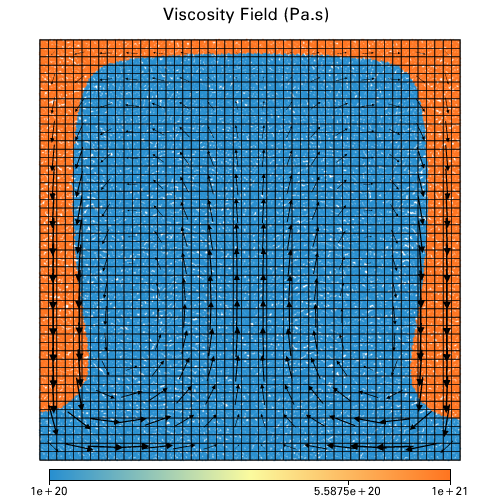

In [23]:
Fig = vis.Figure(figsize=(500,500), title="Viscosity Field (Pa.s)", quality=3)
Fig.Mesh(Model.mesh)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()


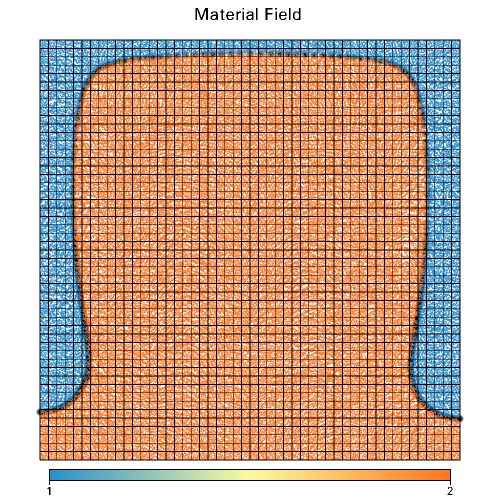

In [24]:
Fig = vis.Figure(figsize=(500,500), title="Material Field", quality=2)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.Mesh(Model.mesh)
Fig.Points(Model.Surface_tracers, pointSize=8.0)
Fig.show()